In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from toolz import *

# Why Prediction Metrics are Dangerous For Causal Models
 
A common misconception I often hear is that, if we have random data, to evaluate a causal model we could just evaluate the predictive performance of such model on the random dataset, using a metric like $R^2$. Unfortunately things are not that simple and I'll try to explain why. 
 
Generally speaking, we can say any outcome is a function of the treatment and covariates
 
$$
Y = F(x, t)
$$
 
Let's say we can decompose this function into two additive pieces. One piece that doesn't depend on the treatment and another that depends only on the treatment and possible interactions.
 
$$
Y = g(x) + f(t,x)
$$
 
This additive structure places some restriction on the functional form but not much, so we can argue it is a pretty general way of describing a Data Generating Process (DGP).
 
The point is that if the treatment effect is weaker than the covariates effect, then, **even if we have random data**, we can have a model which has higher predictive power but is bad for causal inference. All that model has to do is approximate $g(x)$ while disregarding $f(t,x)$.
 
In other words, **predictive performance on a random dataset does not translate our preference for how good a model is for causal inference**.
 
To show that, let's use some simulated data.
 
## Simulating Data
 
In the following DGP, we have covariates $X$ that have a high predictive power but don't interact with the treatment. In other words, they don't dictate the treatment effect heterogeneity. We also have features $W$ that only impact the outcome through the treatment (are not confounders). Since the treatment has low predictive power, $W$ also doesn't have much predictive power.
 
$$
Y_i = g(X_i) + f(T_i,W_i) + e_i
$$

In [2]:
n = 100000
n_features = 20
n_heter = 10

np.random.seed(12321)

X = np.random.normal(1, 10, (n, n_features))
nuisance = np.random.uniform(-1,1, (n_features, 1))

W = np.random.normal(1, 10, (n, n_heter))
heter_y = np.random.uniform(-1,1, (n_heter, 1))

T = np.random.normal(10, 2, (n, 1)) # T is random!
Y = np.random.normal(T + T*W.dot(heter_y) + 20*X.dot(nuisance), 0.1)

df = pd.concat([
    pd.DataFrame(X, columns=[f"f{f}" for f in range(n_features)]),
    pd.DataFrame(W, columns=[f"w{f}" for f in range(n_heter)])
], axis=1).assign(T=T, Y=Y)

Now, let's break that dataset into a training and a test set

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.5)
train.shape, test.shape

((50000, 32), (50000, 32))

and train two models for treatment effect heterogeneity, $M1$ and $M2$. $M1$ will include the highly predictive features that don't affect the treatment heterogeneity and $M2$ will include the low predictive features that do affect treatment heterogeneity.

In [4]:
m1 = smf.ols("Y~T*(" + "+".join([f"f{f}" for f in range(n_features)])+")", data=df).fit()
m2 = smf.ols("Y~T*(" + "+".join([f"w{f}" for f in range(n_heter)])+")", data=df).fit()

If we look at the predictive power of both models using the $R^2$, indeed, $M1$ is much better than $M2$. 

In [6]:
from sklearn.metrics import r2_score

print("M1:", r2_score(test["Y"], m1.predict(test)))
print("M2:", r2_score(test["Y"], m2.predict(test)))

M1: 0.9160516511287358
M2: 0.08378351037639298


Now, let's calculate the cumulative elasticity curve for both models. For that, we will need Conditional Average Treatment Effect predictions. Since all the models here are linear, we can use the following formula to get CATE predictions
 
$$
\hat{CATE_i} = M(X, W, t) - M(X, W, t-1)
$$

In [8]:
@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))
    

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])


In [9]:
test_pred = test.assign(
    cate_1 = m1.predict(test) - m1.predict(test.assign(T=test["T"]-1)),
    cate_2 = m2.predict(test) - m2.predict(test.assign(T=test["T"]-1))
)

Once we have those CATE predictions, we can evaluate them using the cumulative elasticity curve

In [11]:
cumelast_1 = cumulative_gain(test_pred, "cate_1", "Y", "T", steps=100)
cumelast_2 = cumulative_gain(test_pred, "cate_2", "Y", "T", steps=100)

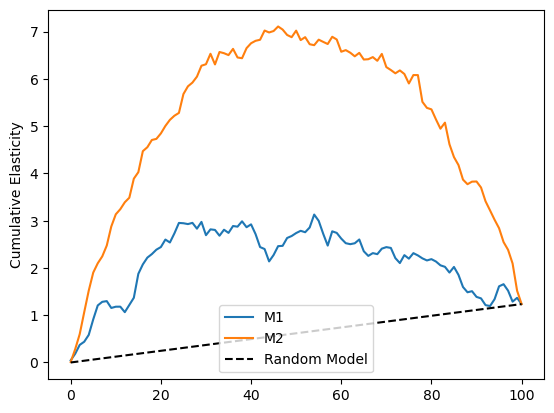

In [12]:
plt.plot(range(len(cumelast_1)), cumelast_1, label="M1")
plt.plot(range(len(cumelast_2)), cumelast_2, label="M2")
plt.plot([0, 100], [0, elast(test_pred, "Y", "T")], linestyle="--", label="Random Model", color="black")
plt.legend()
plt.ylabel("Cumulative Elasticity");

As we can see, now $M1$ is much worse than $M2$, even though it has a higher $R^2$ on the test set. This shows that predictive power doesn't translate directly to a good causal model, even if we use random data.

## Predictive Metric For Causal Inference
 
This doesn't mean we can't come up with a way to correctly evaluate a causal model using predictive metrics. In order to do so, let's go back to our additive assumption about de DGP.
 
$$
Y = g(x) + f(t,x)
$$
 
To use a predictive metric, we need to somehow transform the outcome in order to remove the $g(x)$ component from it. That way, all the remaining predictive power will necessarily be used to learn the causal relationship.
 
$$
\tilde{Y} = Y - g(x) = f(t,x)
$$
 
One way of doing that is by orthogonalizing $Y$. We can use any ML model to estimate $g$ and get out of fold residuals
 
$$
\tilde{Y} = Y - \hat{g}(x)
$$

In [15]:
denoise_m = smf.ols("Y~"+
                    "+".join([f"w{f}" for f in range(n_heter)])+
                    "+"+
                    "+".join([f"f{f}" for f in range(n_features)]), data=train).fit()

test_res = test.assign(Y_res = test["Y"] - denoise_m.predict(test) + test["Y"].mean())

Once we do that, we can evaluate the power of each model in predicting the residualized outcome $\tilde{Y}$. The predictive performance on this new outcome will directly translate to a better causal model.

In [ ]:
print("M1:", r2_score(test_res["Y_res"], m1.predict(test_res)))
print("M2:", r2_score(test_res["Y_res"], m2.predict(test_res)))

The downside of this approach is that it depends on how well you can estimate $g(x)$.